In [2]:
"""
analyse_pib_2024.py
Script : récupère les données World Bank, calcule comparaisons 2024 vs 2023,
génère tableaux et graphiques (top20 PIB nominal, PIB par habitant, variations).
"""

import requests
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIG ---
YEARS = [2023, 2024]       # années à comparer
TOP_N = 20                 # nombre de pays à afficher dans les classements
OUT_DIR = "output_pib_2024"  # dossier de sortie

# Indicators (World Bank)
# NY.GDP.MKTP.CD     -> GDP (current US$)
# NY.GDP.PCAP.CD     -> GDP per capita (current US$)
# NY.GDP.MKTP.KD.ZG  -> GDP growth (annual %)
INDICATORS = {
    "gdp_nominal": "NY.GDP.MKTP.CD",
    "gdp_per_capita": "NY.GDP.PCAP.CD",
    "gdp_growth_pct": "NY.GDP.MKTP.KD.ZG"
}

WB_API_BASE = "https://api.worldbank.org/v2/country/all/indicator/{indicator}"

# --- UTILS ---
def fetch_wb_indicator(indicator_code, years, per_page=20000):
    """Retourne un DataFrame indexé par pays, colonnes = années demandées."""
    url = WB_API_BASE.format(indicator=indicator_code)
    params = {
        "date": f"{min(years)}:{max(years)}",
        "format": "json",
        "per_page": per_page
    }
    print(f"Téléchargement {indicator_code} ...")
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    # data[1] contient la liste d'entrées
    records = []
    if len(data) < 2 or data[1] is None:
        return pd.DataFrame()
    for entry in data[1]:
        country = entry.get("country", {}).get("value")
        countryiso3 = entry.get("countryiso3code")
        year = int(entry.get("date"))
        value = entry.get("value")
        records.append({
            "country": country,
            "iso3": countryiso3,
            "year": year,
            "value": value
        })
    df = pd.DataFrame(records)
    # pivot pour avoir une colonne par année
    df_pivot = df.pivot_table(index=["country", "iso3"], columns="year", values="value").reset_index()
    # renommer colonnes années en str pour cohérence
    df_pivot.columns = [str(c) if isinstance(c, int) else c for c in df_pivot.columns]
    return df_pivot

def ensure_outdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# --- PIPELINE ---
def main():
    ensure_outdir(OUT_DIR)

    # 1) Téléchargement des 3 indicateurs
    dfs = {}
    for key, code in INDICATORS.items():
        df = fetch_wb_indicator(code, YEARS)
        if df.empty:
            print(f"Attention : pas de données pour {code}")
        dfs[key] = df

    # 2) Merge des indicateurs sur country + iso3
    # Commencer à partir de gdp_nominal comme base de pays
    base = dfs["gdp_nominal"].copy()
    base = base.rename(columns={str(YEARS[0]): f"gdp_nominal_{YEARS[0]}",
                                str(YEARS[1]): f"gdp_nominal_{YEARS[1]}"})
    for key in ["gdp_per_capita", "gdp_growth_pct"]:
        df = dfs.get(key)
        if df is None or df.empty:
            continue
        rename_map = {
            str(YEARS[0]): f"{key}_{YEARS[0]}",
            str(YEARS[1]): f"{key}_{YEARS[1]}"
        }
        df = df.rename(columns=rename_map)
        base = base.merge(df[["country", "iso3"] + list(rename_map.values())],
                          on=["country", "iso3"], how="outer")

    # 3) Calculs : delta et classement
    # Variation nominale (USD) et variation en % approximative si possible
    base["delta_gdp_nominal_usd"] = base.get(f"gdp_nominal_{YEARS[1]}") - base.get(f"gdp_nominal_{YEARS[0]}")
    # variation % = (2024 - 2023) / 2023 * 100, sans division par zéro
    def pct_change(a, b):
        try:
            if pd.isna(a) or a == 0:
                return None
            return (b - a) / a * 100.0
        except Exception:
            return None

    base["pct_change_gdp_nominal"] = base.apply(
        lambda row: pct_change(row.get(f"gdp_nominal_{YEARS[0]}"), row.get(f"gdp_nominal_{YEARS[1]}")),
        axis=1
    )

    # Classements top N par GDP nominal 2024
    df_top_nominal = base[[ "country", "iso3", f"gdp_nominal_{YEARS[1]}", f"gdp_nominal_{YEARS[0]}", "pct_change_gdp_nominal"
                         ]].dropna(subset=[f"gdp_nominal_{YEARS[1]}"]).sort_values(by=f"gdp_nominal_{YEARS[1]}", ascending=False).head(TOP_N)
    df_top_nominal.index = range(1, len(df_top_nominal) + 1)

    # Top par PIB par habitant 2024
    df_top_pc = base[[ "country", "iso3", f"gdp_per_capita_{YEARS[1]}", f"gdp_per_capita_{YEARS[0]}"
                     ]].dropna(subset=[f"gdp_per_capita_{YEARS[1]}"]).sort_values(by=f"gdp_per_capita_{YEARS[1]}", ascending=False).head(TOP_N)
    df_top_pc.index = range(1, len(df_top_pc) + 1)

    # Top pays avec plus forte croissance (2024 vs 2023) d'après growth_pct indicator (si dispo)
    if f"gdp_growth_pct_{YEARS[1]}" in base.columns:
        df_growth = base[[ "country", "iso3", f"gdp_growth_pct_{YEARS[1]}", f"gdp_growth_pct_{YEARS[0]}"
                         ]].dropna(subset=[f"gdp_growth_pct_{YEARS[1]}"]).sort_values(by=f"gdp_growth_pct_{YEARS[1]}", ascending=False).head(TOP_N)
        df_growth.index = range(1, len(df_growth) + 1)
    else:
        df_growth = pd.DataFrame()

    # 4) Sauvegardes CSV
    df_top_nominal.to_csv(os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_nominal_{YEARS[1]}.csv"), index_label="rank")
    df_top_pc.to_csv(os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_percapita_{YEARS[1]}.csv"), index_label="rank")
    if not df_growth.empty:
        df_growth.to_csv(os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_growth_pct_{YEARS[1]}.csv"), index_label="rank")
    base.to_csv(os.path.join(OUT_DIR, f"wb_combined_{YEARS[0]}_{YEARS[1]}.csv"), index=False)

    print(f"Fichiers CSV sauvegardés dans '{OUT_DIR}'")

    # 5) Graphiques : Top 20 PIB nominal 2024 (bar chart)
    plt.figure(figsize=(12, 8))
    # sécuriser la liste des valeurs et noms
    names = df_top_nominal["country"].tolist()[::-1]  # inverser pour barh
    values = df_top_nominal[f"gdp_nominal_{YEARS[1]}"].tolist()[::-1]
    plt.barh(names, values)
    plt.title(f"Top {TOP_N} pays par PIB nominal ({YEARS[1]}) — Source: World Bank")
    plt.xlabel("PIB nominal (USD)")
    plt.tight_layout()
    fname = os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_nominal_{YEARS[1]}.png")
    plt.savefig(fname, dpi=200)
    plt.close()
    print(f"Graphique enregistré : {fname}")

    # 6) Graphique : Top 20 PIB par habitant 2024
    plt.figure(figsize=(12, 8))
    names = df_top_pc["country"].tolist()[::-1]
    values = df_top_pc[f"gdp_per_capita_{YEARS[1]}"].tolist()[::-1]
    plt.barh(names, values)
    plt.title(f"Top {TOP_N} pays par PIB par habitant ({YEARS[1]}) — Source: World Bank")
    plt.xlabel("PIB par habitant (USD)")
    plt.tight_layout()
    fname2 = os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_percapita_{YEARS[1]}.png")
    plt.savefig(fname2, dpi=200)
    plt.close()
    print(f"Graphique enregistré : {fname2}")

    # 7) Graphique : évolution relative 2023 -> 2024 pour top 20 (en %)
    plt.figure(figsize=(12, 8))
    nom_countries = df_top_nominal["country"].tolist()
    nom_pct = df_top_nominal["pct_change_gdp_nominal"].tolist()
    # remplacer None par nan pour tracé
    nom_pct_clean = [x if x is not None else float("nan") for x in nom_pct]
    plt.bar(nom_countries, nom_pct_clean)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% de variation du PIB nominal (2023 -> 2024)")
    plt.title(f"Variation % du PIB nominal (2023 -> 2024) — Top {TOP_N} PIBs")
    plt.tight_layout()
    fname3 = os.path.join(OUT_DIR, f"variation_pct_top_{TOP_N}_gdp_nominal_2023_2024.png")
    plt.savefig(fname3, dpi=200)
    plt.close()
    print(f"Graphique enregistré : {fname3}")

    # 8) Résumé imprimé
    print("\n--- Résumé ---")
    print(f"Top {TOP_N} par PIB nominal {YEARS[1]} (aperçu) :")
    print(df_top_nominal[[ "country", f"gdp_nominal_{YEARS[1]}", "pct_change_gdp_nominal" ]].head(10).to_string(index=True))
    print("\nCSV et PNGs disponibles dans le dossier:", OUT_DIR)
    print("Script terminé.")

if __name__ == "__main__":
    main()


Téléchargement NY.GDP.MKTP.CD ...
Téléchargement NY.GDP.PCAP.CD ...
Téléchargement NY.GDP.MKTP.KD.ZG ...
Fichiers CSV sauvegardés dans 'output_pib_2024'
Graphique enregistré : output_pib_2024/top_20_gdp_nominal_2024.png
Graphique enregistré : output_pib_2024/top_20_gdp_percapita_2024.png
Graphique enregistré : output_pib_2024/variation_pct_top_20_gdp_nominal_2023_2024.png

--- Résumé ---
Top 20 par PIB nominal 2024 (aperçu) :
                      country  gdp_nominal_2024  pct_change_gdp_nominal
1                       World      1.112530e+14                4.033830
2                 High income      7.152300e+13                4.232427
3                OECD members      6.768705e+13                4.449685
4   Post-demographic dividend      6.304064e+13                4.132545
5            IDA & IBRD total      4.391812e+13                3.990649
6                   IBRD only      4.110222e+13                4.199234
7         Low & middle income      3.921694e+13                3.6

--- Top 20 PIB Nominal (2024) ---


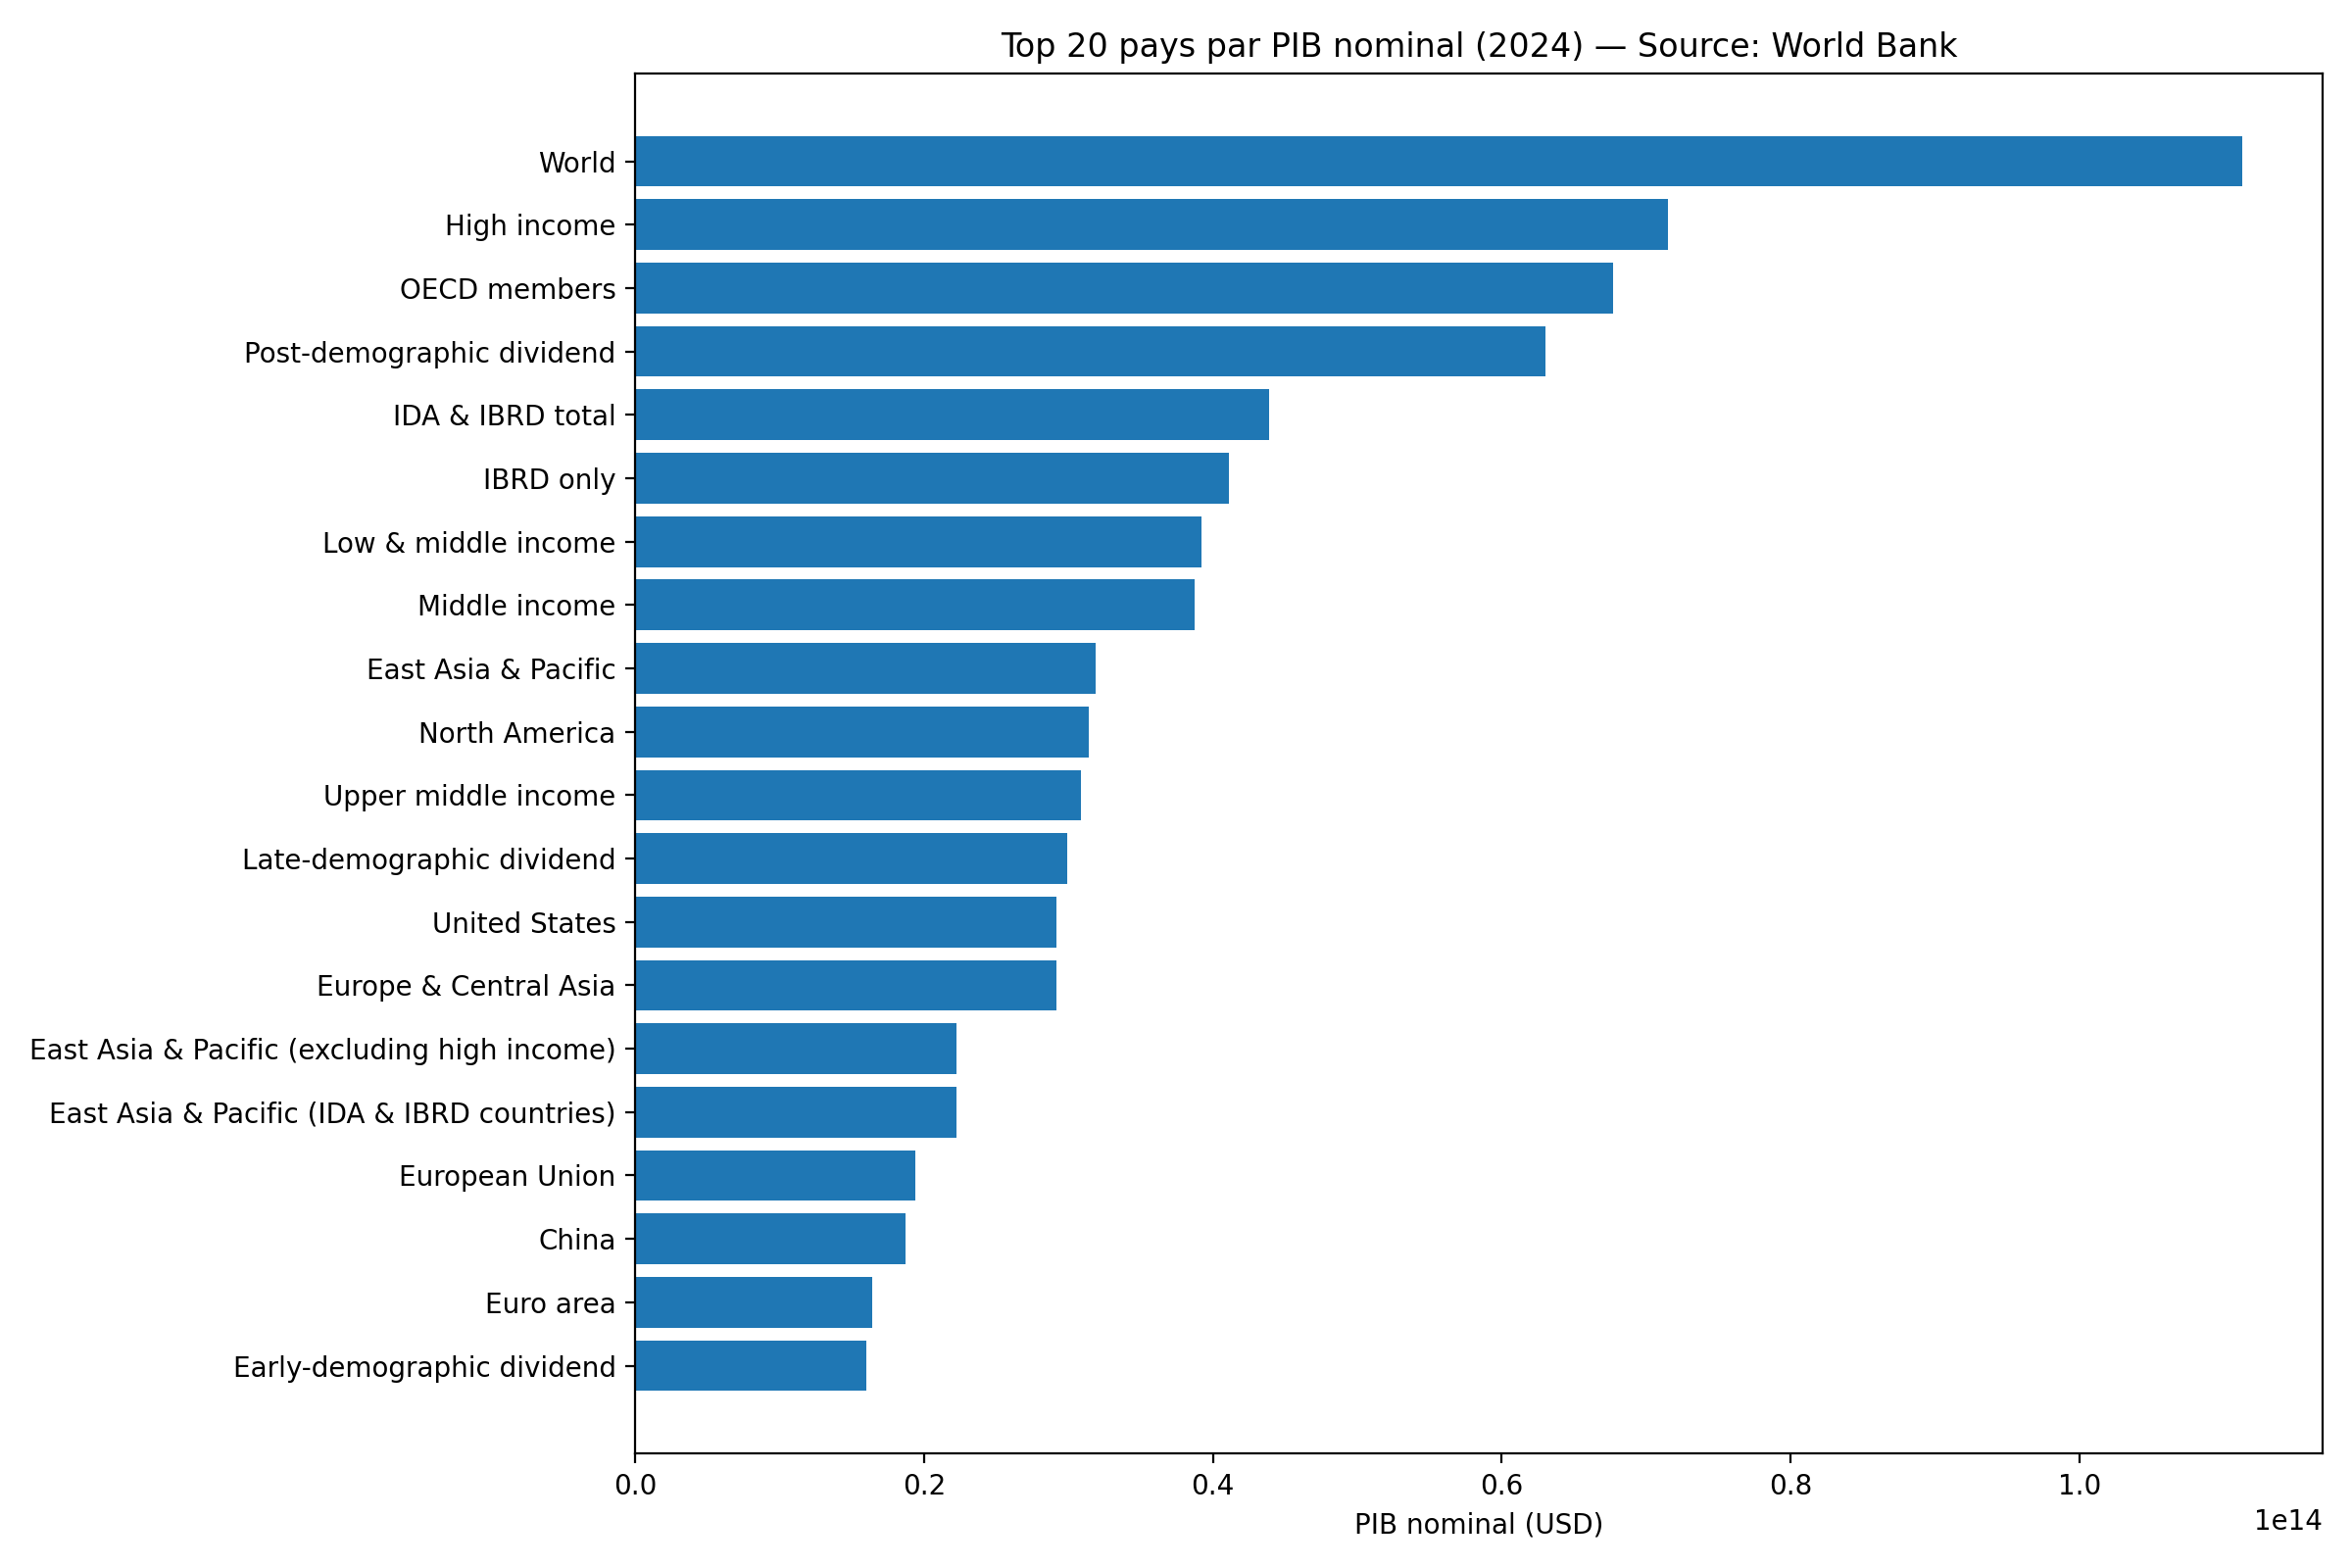


--- Top 20 PIB par habitant (2024) ---


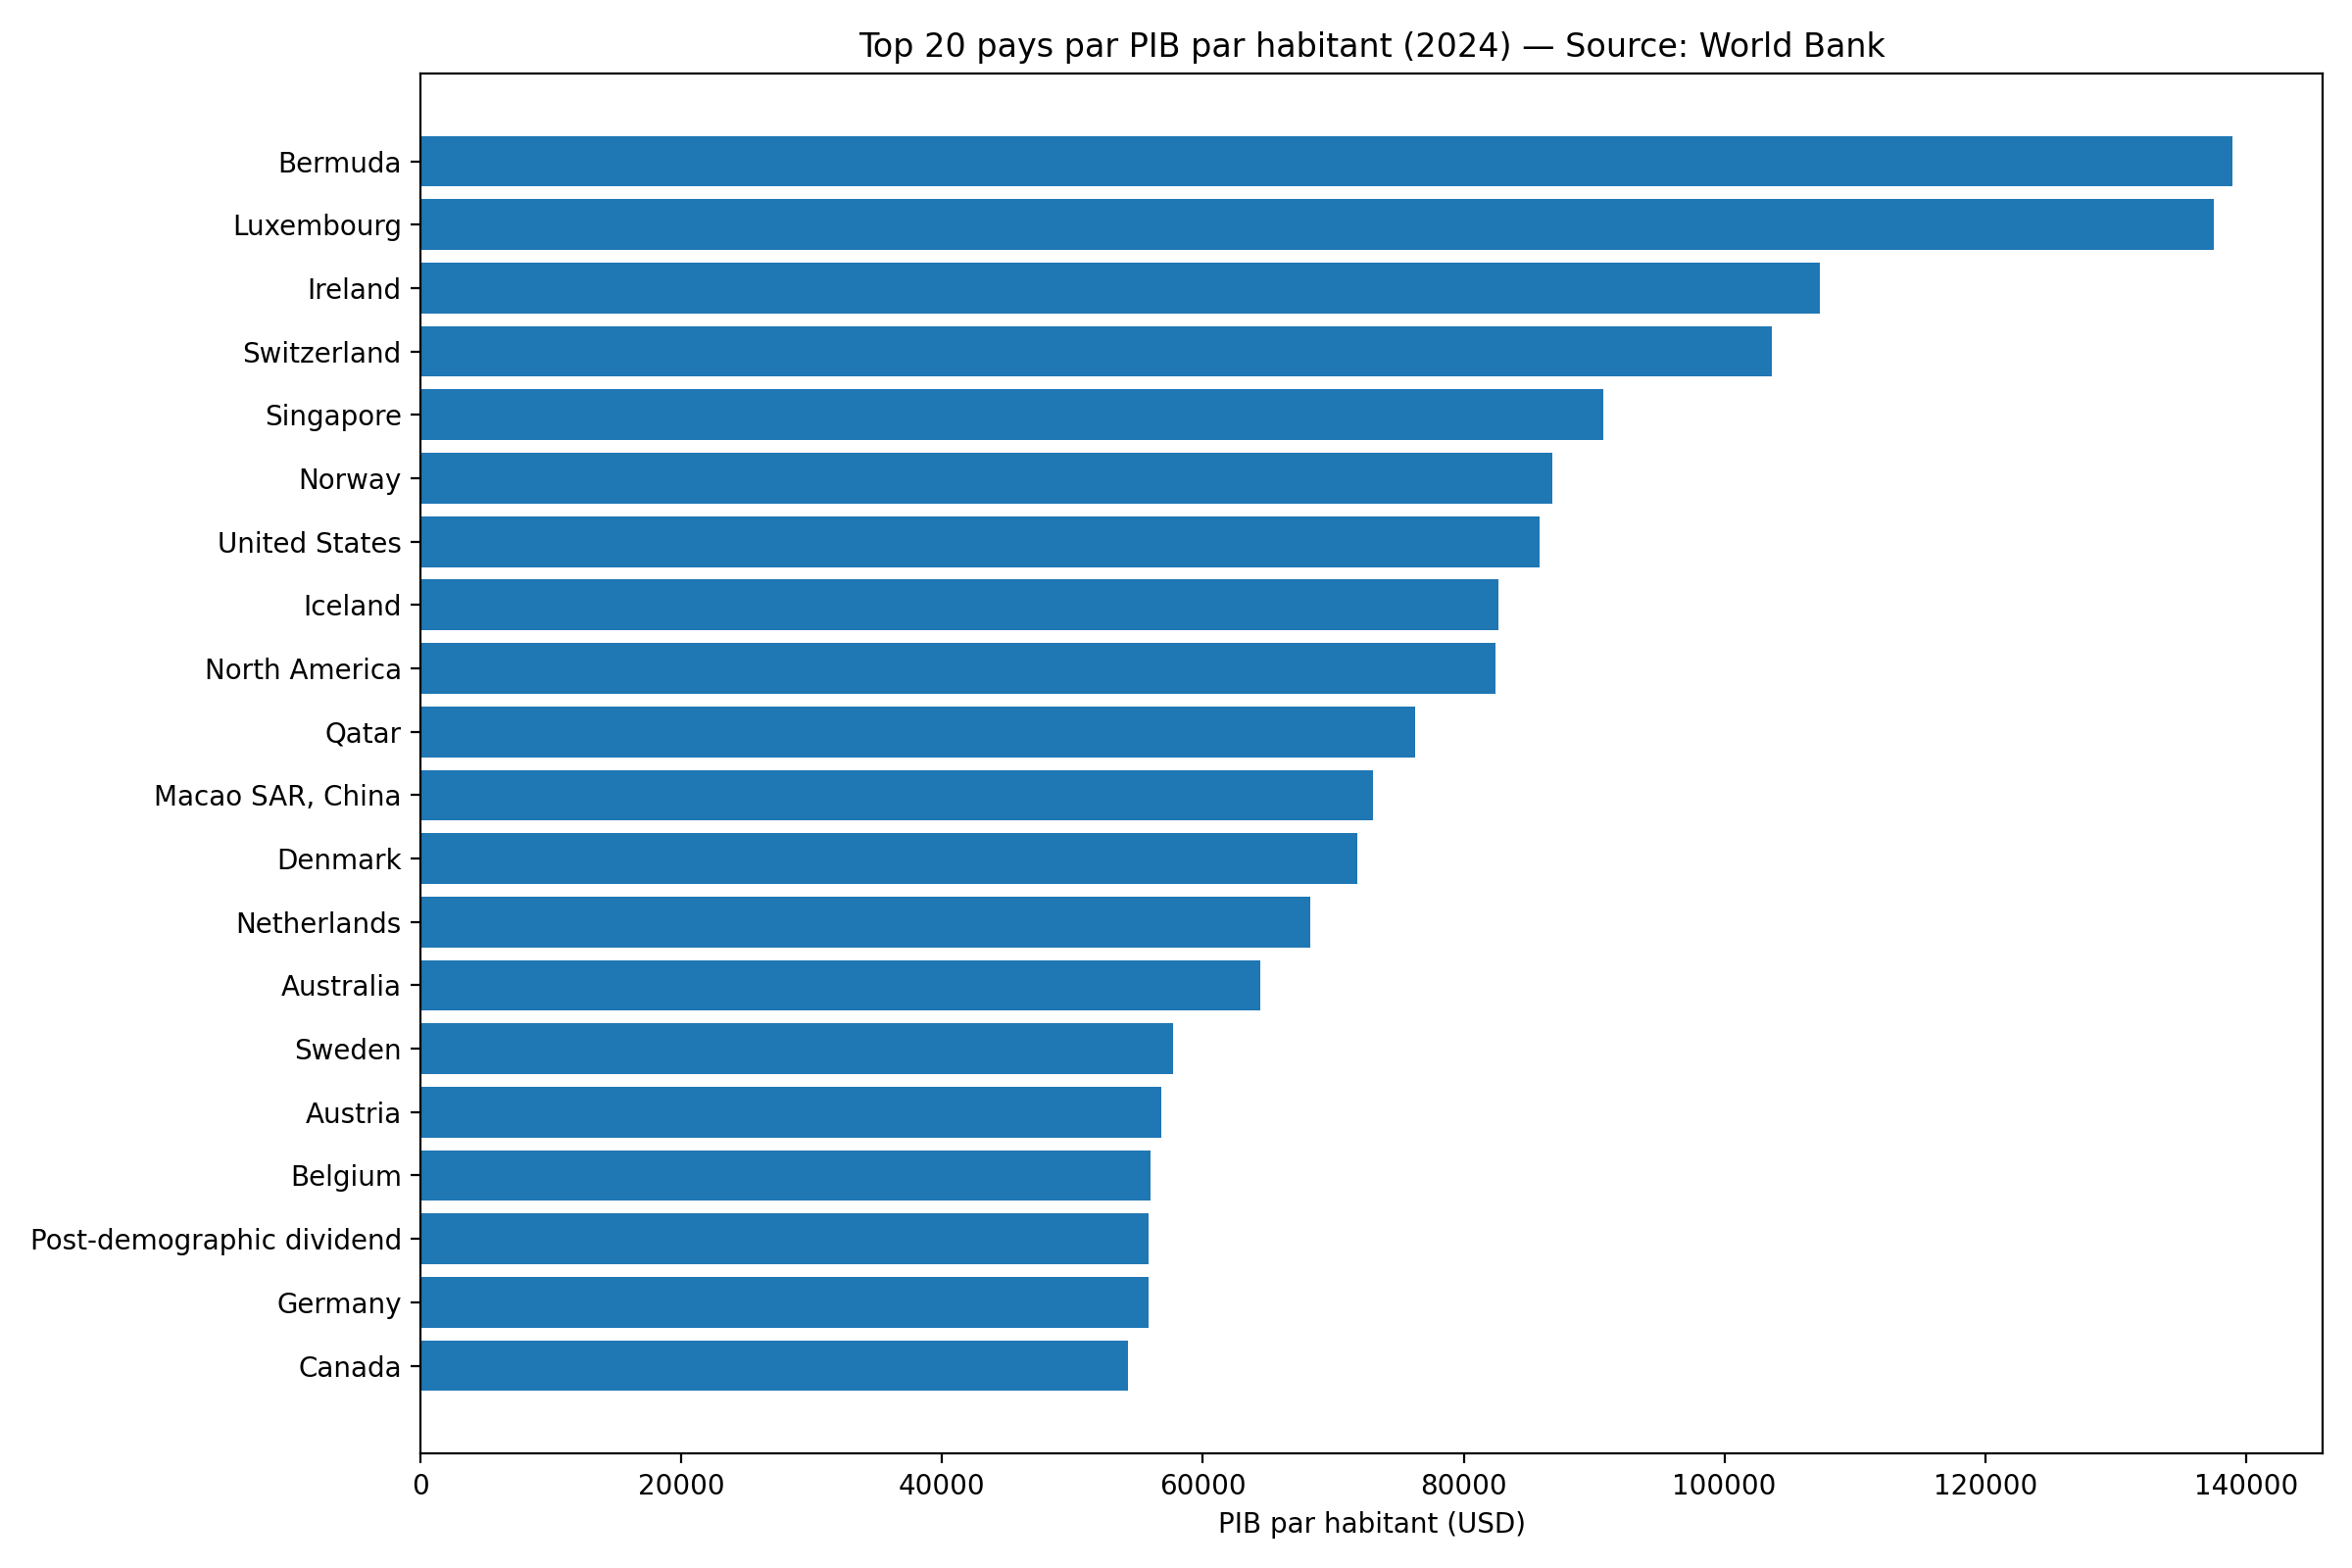


--- Variation % du PIB Nominal (2023 -> 2024) pour Top 20 PIBs ---


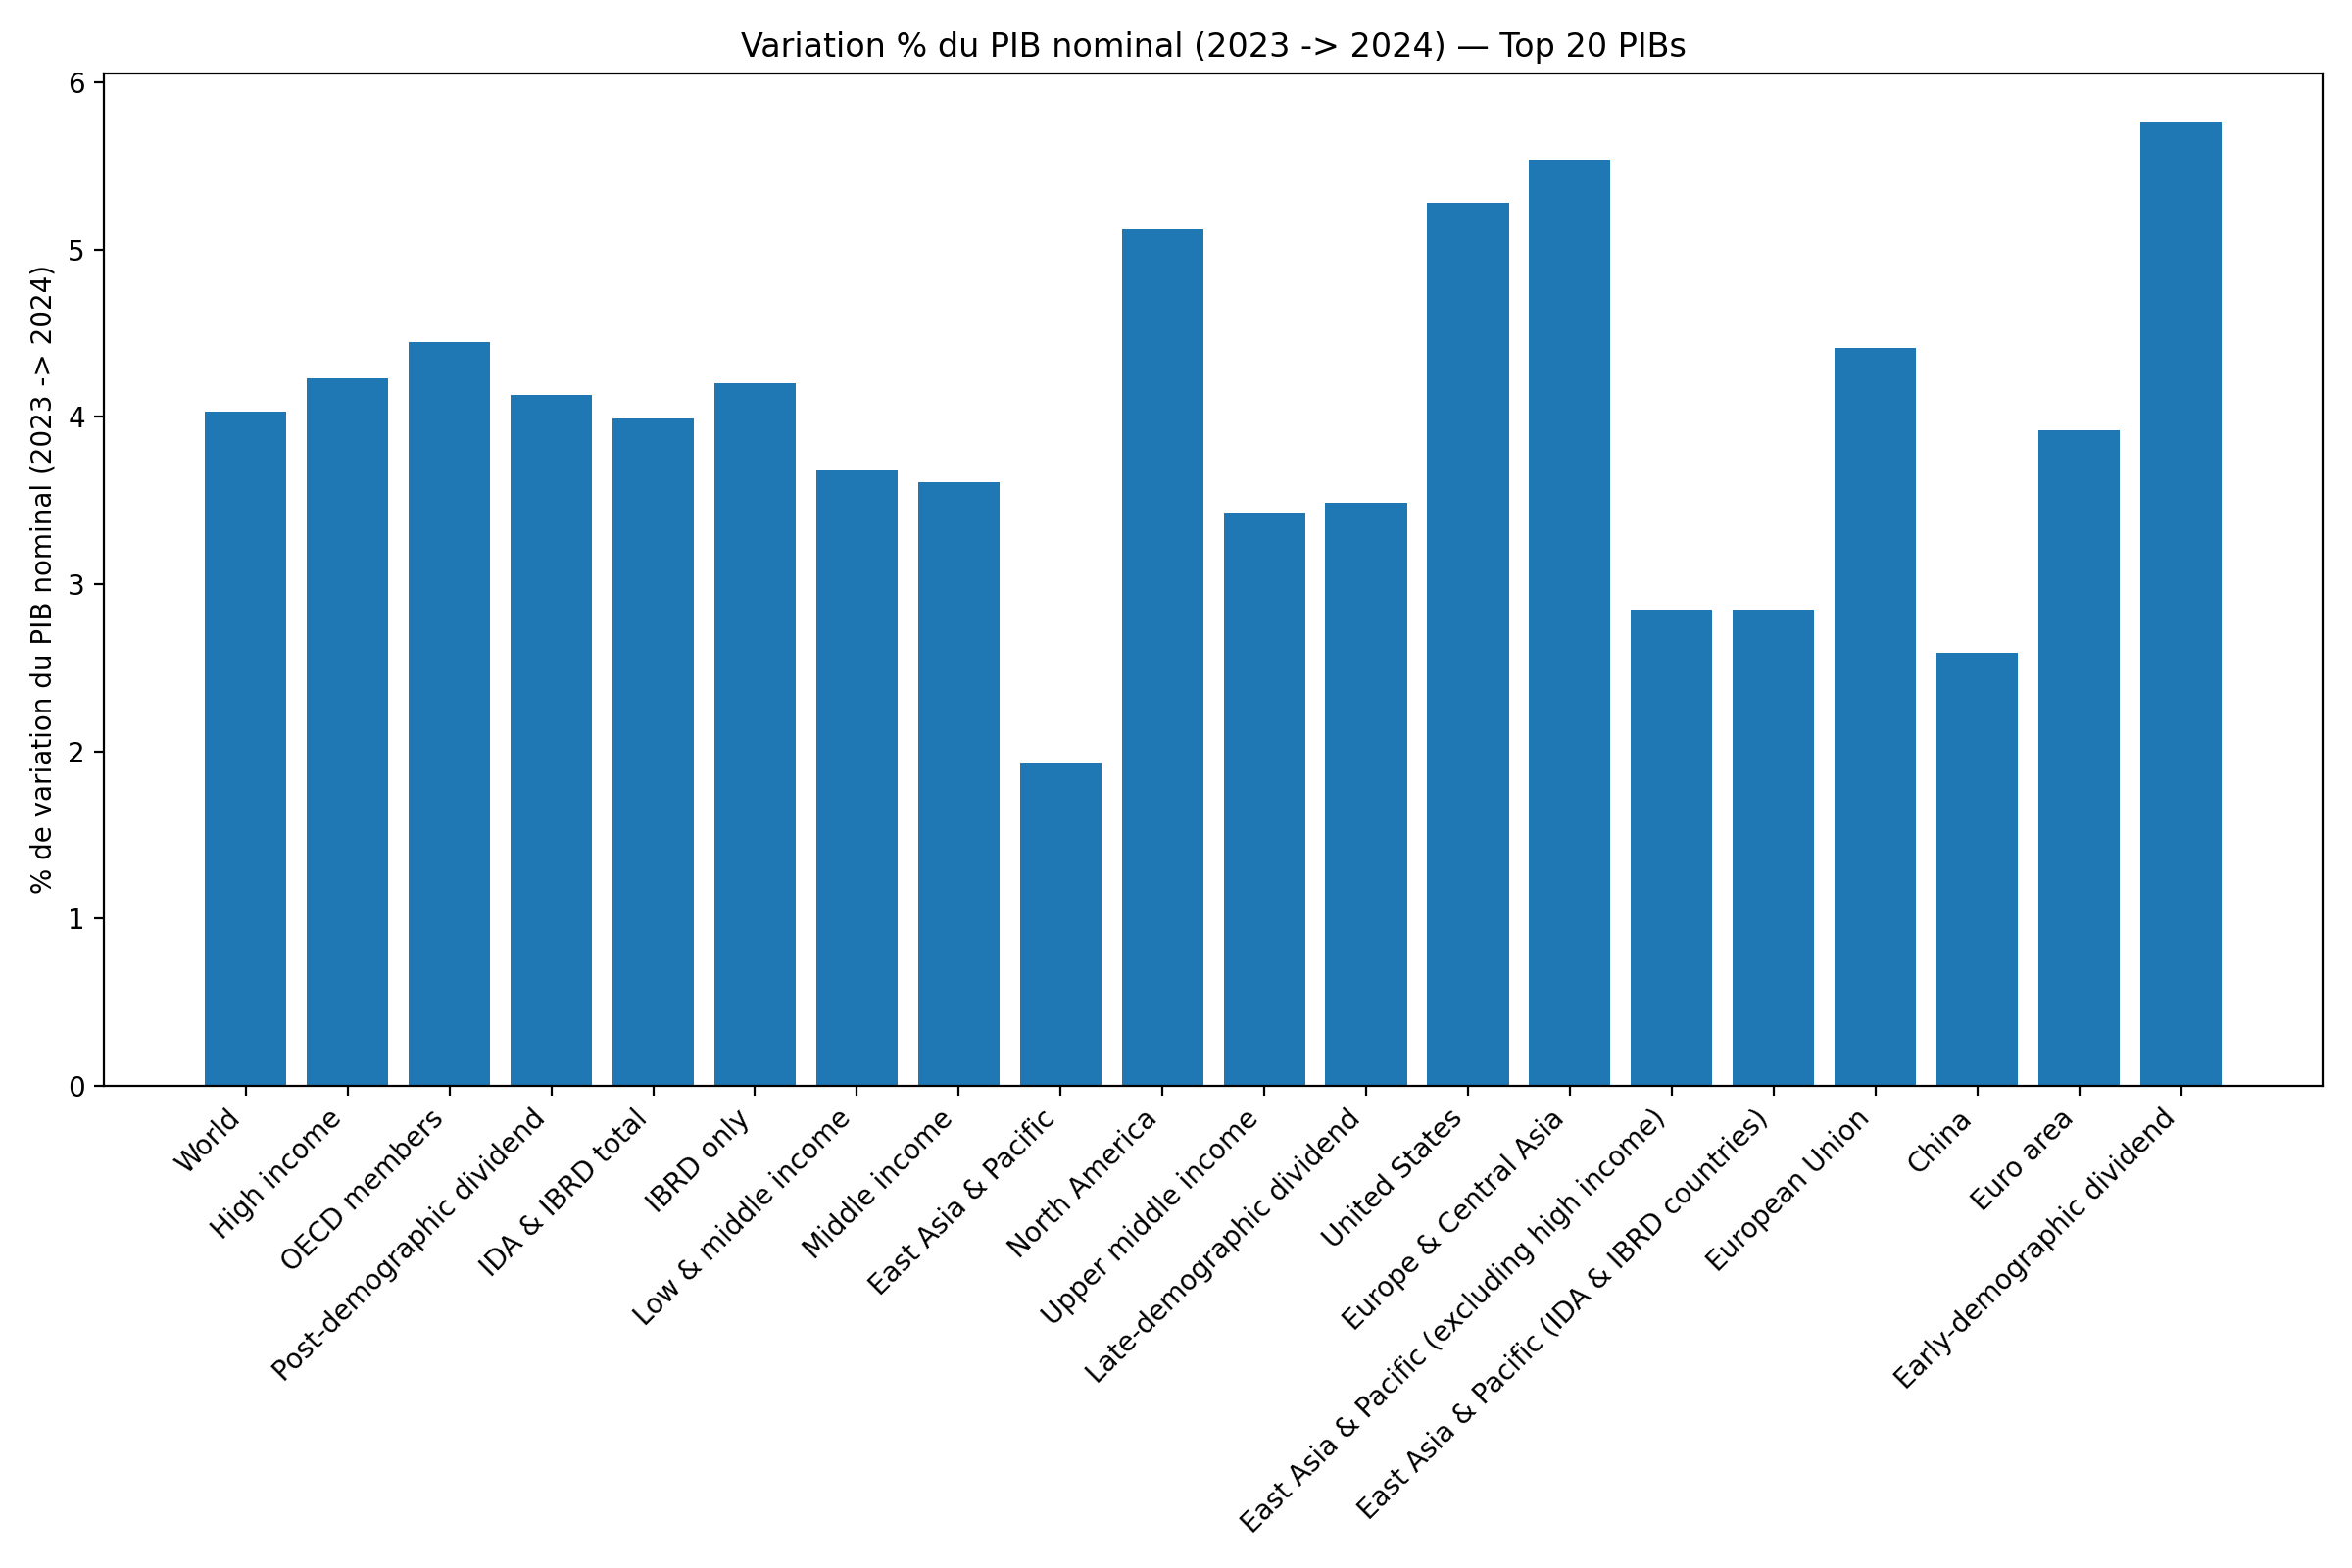

Graphique 'output_pib_2024/top_20_gdp_growth_pct_2024.png' non trouvé (peut-être pas de données 2024 disponibles).


In [7]:
from IPython.display import Image, display
import os

OUT_DIR = "output_pib_2024"
YEARS = [2023, 2024]
TOP_N = 20

# Display Top 20 GDP Nominal chart
gdp_nominal_chart_path = os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_nominal_{YEARS[1]}.png")
if os.path.exists(gdp_nominal_chart_path):
    print(f"--- Top {TOP_N} PIB Nominal ({YEARS[1]}) ---")
    display(Image(filename=gdp_nominal_chart_path))
else:
    print(f"Graphique '{gdp_nominal_chart_path}' non trouvé.")

# Display Top 20 GDP Per Capita chart
gdp_percapita_chart_path = os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_percapita_{YEARS[1]}.png")
if os.path.exists(gdp_percapita_chart_path):
    print(f"\n--- Top {TOP_N} PIB par habitant ({YEARS[1]}) ---")
    display(Image(filename=gdp_percapita_chart_path))
else:
    print(f"Graphique '{gdp_percapita_chart_path}' non trouvé.")

# Display Percentage Change in Nominal GDP chart
pct_change_chart_path = os.path.join(OUT_DIR, f"variation_pct_top_{TOP_N}_gdp_nominal_2023_2024.png")
if os.path.exists(pct_change_chart_path):
    print(f"\n--- Variation % du PIB Nominal ({YEARS[0]} -> {YEARS[1]}) pour Top {TOP_N} PIBs ---")
    display(Image(filename=pct_change_chart_path))
else:
    print(f"Graphique '{pct_change_chart_path}' non trouvé.")

# You can also display the growth chart if it was generated
gdp_growth_chart_path = os.path.join(OUT_DIR, f"top_{TOP_N}_gdp_growth_pct_{YEARS[1]}.png")
if os.path.exists(gdp_growth_chart_path):
    print(f"\n--- Top {TOP_N} Taux de Croissance du PIB ({YEARS[1]}) ---")
    display(Image(filename=gdp_growth_chart_path))
else:
    print(f"Graphique '{gdp_growth_chart_path}' non trouvé (peut-être pas de données 2024 disponibles).")